### What is Parallelization in langGraph ? 

In langGraph, nodes typically execute in a sequence defined by edges, but when tasks don't depend on each other's output, you can run them in parallel. this is achieved by : 

- Defining multiple nodes that can operate independently.

- connecting them to a common starting point (to START or other nodes )

- merging their outputs into a downstream node if needed. 

LangGraph handles this implicitly when nodes are independent and can leverage multi-threading or asynchronous execution under the hood, depending on the runtime envionment( eg. python's asyncio or a multi-threaded executor.)

![](../images/img5.png)

In [23]:
import os 
from dotenv import load_dotenv

load_dotenv()

from langchain_groq import ChatGroq 
from langchain_openai import ChatOpenAI
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API")
os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")

In [ ]:
llm=ChatGroq(model="openai/gpt-oss-120b")
# llm=ChatOpenAI(model="gpt-5-2025-08-07")

In [13]:
llm.invoke("hi")

AIMessage(content='Hello! How can I help you today?', additional_kwargs={'reasoning_content': 'The user says "hi". We just respond politely.'}, response_metadata={'token_usage': {'completion_tokens': 30, 'prompt_tokens': 72, 'total_tokens': 102, 'completion_time': 0.065033204, 'prompt_time': 0.003547558, 'queue_time': 0.43062999, 'total_time': 0.068580762}, 'model_name': 'openai/gpt-oss-120b', 'system_fingerprint': 'fp_82669fd91d', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--8d04da20-2f22-4e86-9cde-a7f3ea2b8b44-0', usage_metadata={'input_tokens': 72, 'output_tokens': 30, 'total_tokens': 102})

In [27]:
from typing_extensions import Annotated
from typing import TypedDict

from langgraph.graph import START,END,StateGraph

class State(TypedDict):
    topic:str
    character:str
    premise:str
    setting:str
    final_story:str


In [28]:
# Creating nodes 

def generate_character(state:State):
    """ Generate character descriptions"""
    msg=llm.invoke(f"create two character names and brief traits for a story about {state['topic']}")
    return{'character':msg.content}

def generate_setting(state:State):
    """ Generate a story setting"""
    msg=llm.invoke(f"Describe a vivid setting for a story about {state['topic']}")
    return {"setting":msg.content}

def generate_premise(state:State):
    """Generate a story permise"""
    msg=llm.invoke(f"Write a one sentence plot premise for a story about {state['topic']}")
    return {"premise":msg.content}

def combine_elements(state:State):
    """ Combine characters , setting , and premise into an intro"""

    msg=llm.invoke(
        f"Write a short story introduction using these elements:\n"
        f"characters: {state['character']}\n"
        f"setting:{state["setting"]}\n"
        f"Premise: {state['premise']}"
    )

    return {"final_story":msg.content}

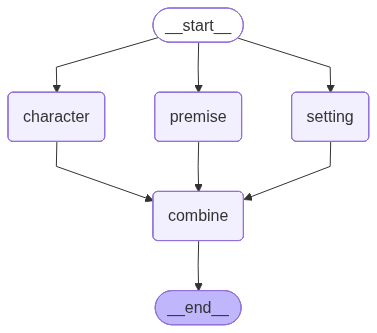

In [29]:
builder=StateGraph(State)

builder.add_node("character",generate_character)
builder.add_node("setting",generate_setting)
builder.add_node("premise",generate_premise)
builder.add_node("combine",combine_elements)

## add edges 
builder.add_edge(START,"character")
builder.add_edge(START,"setting")
builder.add_edge(START,"premise")
builder.add_edge("character","combine")
builder.add_edge("setting","combine")
builder.add_edge("premise","combine")

builder.add_edge("combine",END)

graph=builder.compile()

from IPython.display import Image,display

display(Image(graph.get_graph().draw_mermaid_png()))

In [30]:
state1={"topic":"time travel"}

result=graph.invoke(state1)

In [31]:
from rich import print
print(result['character'])

- Dr. Nia Calder — Temporal archaeologist who “reads” causality patterns; principled but burdened by a paradox she 
accidentally created; carries a century-old pocket watch that doubles as a time-lock key.

- Casimir Locke — Former black-market time courier from an erased timeline; charming, impulsive, and partially 
immune to minor edits; desperate to restore his vanished sister, even if it risks a cascade failure.

In [32]:
print(result['final_story'])

Dr. Nia Calder did not look up. The trick of the Tidemarket was keeping your eyes level with the now—on the slick 
black boards underfoot, the braided ropes at your hands, the ledgers that remembered more than ink. If you let the 
sky have you, the layered weather of it, you lost time you couldn’t afford.

Her anchors clinked when the paradox wind came off the flats—her mother’s plain gold band on a chain, a bead of 
amber with an insect that had not happened yet, and the century-old pocket watch that thudded against her ribs like
a small, stubborn heart. The watch was heavy as a law. Its face had been polished nearly blind by other hands; 
inside the case, tiny teeth ached to bite. It was her anchor, and the key that turned the time-locks she was paid 
to close.

On afternoons like this the market’s buoys beat the harbor into a rhythm you could not memorize. The foghorn on the
point—an old whaler’s horn girdled with copper coil and faith—blew long and low. The smell was the usual braid: hot
tar, salt, singed sugar from a brazier; and in the rain that came down in thin planes you could taste strange 
weather on your tongue. Children ran with jars, chasing moths that refused to die because they hadn’t been born. 
The Harbor Watch stalked by with bells ready in their palms, watching for anyone who might split into a second 
opinion and require persuasion back into singularity.

Nia kept to the boardwalk’s centerline, aware of the way the puddles left by the tide didn’t agree. In one pool the
reflection of the sky showed box-kites and biplanes; in another, a white fingernail of moon gnashed at noon. She 
read the currents in the glass—cause and effect curling like eelgrass, knotting and unknotting. Some people saw 
time as a ribbon. For Nia it was weather: pressure systems, draft and drag. Today there was a bruise in the air 
where two fronts met, and she felt it like a healed fracture before storm.

“Officer Calder,” said Casimir Locke, leaning against the pilings where a gull had staked a claim and was losing 
the argument. “You look like someone who hasn’t had her cup of 2099.”

He had a paper cup in each hand, steam ghosting upward in two slightly different centuries. He handed her the 
sharper one—metal-sweet, a thin green taste at the back of the teeth—and held the other to his lips. His anchors 
were showy as always: a chain of rusted keys that had never opened any door in this version of events, a quartz 
pendant with a flaw like a frozen lightning strike. The paradox wind tugged his hair, but he didn’t chime. Edits 
slid off him like rain off wax paper.

“You’re late,” Nia said, and flipped open her ledger. The ledger’s paper was eel-skin thin and prone to yielding up
next hour’s notations if you held it too near a heat source. She kept it cool with a strip of tomorrow’s ice tucked
in the back cover.

“Late and early,” he said cheerfully. “I was on time in a place that will never be, and I feel I should get partial
credit. Also, the dog that barks in telegraph told me you’d be forgiving today.”

“Report.”

Casimir sighed as if she’d asked him to file off his own laughter. “Casimir Locke, former courier, erased timeline,
parole number Sigma-Blue. No unauthorized transits. Work: barbacking at the Steamery, two shifts. No contact with 
former employers—hard to contact people who never happened. No charm-work, no white stones. I did bring in a net 
with three crabs and a Roman lamp that smells of olives, which I sold to a woman with a tattoo of the continents 
when they were still fighting.”

“Drift index?”

He titled his hand, and Nia watched the way his outline didn’t fuzz at the edges when a thin curtain of rain passed
through him. Partial immunity did that. He had walked so long at the seams between versions he knew where to place 
his feet.

“Stable enough to dance,” he said. His smile flickered. “Any news?”

Nia didn’t say: I check the morning sheets for a girl who might be your sister in every version of the newspaper

### Key Benefits 

- speed: Reduces total execution time by running tasks concurrently.

- scalability : Handles larger workflows efficiently.

- Modularity : keeps the graph structure clean and reusable.


### key takeaways 

- when to parallelize : use it for independent tasks (eg, generating multiple outputs , checking separate inputs.)

- merging : Downstream nodes can aggregate parallel results.

- langGraph support : the framework naturally supports this by waiting for all required inputd before proceeding.